#1. Imports


In [2]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# 2. Data Preprocessing

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Load CIFAR-10 Dataset

In [4]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


# 4. Sample Image Inspection

In [5]:
image, label = train_data[0]
image.size()

torch.Size([3, 32, 32])

#  5. Class Labels

In [6]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 6. Define CNN Model

In [7]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3,12,5) # (12, 28, 28)
    self.pool = nn.MaxPool2d(2,2) # (12, 14, 14)
    self.conv2 = nn.Conv2d(12,24,5) # (24, 10, 10) -> (24, 5, 5) -> Flatten (24 * 5 * 5)
    self.fc1 = nn.Linear(24*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = self.pool(f.relu(self.conv1(x)))
    x = self.pool(f.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = f.relu(self.fc1(x))
    x = f.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# 7. Loss and Optimizer

In [8]:
net = NeuralNet()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 8. Training Loop

In [9]:
for epoch in range(50):
  print(f'Training epoch {epoch}...')

  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f'Loss: {running_loss/len(train_loader):.4f}')

Training epoch 0...
Loss: 2.2027
Training epoch 1...
Loss: 1.7798
Training epoch 2...
Loss: 1.5432
Training epoch 3...
Loss: 1.4175
Training epoch 4...
Loss: 1.3303
Training epoch 5...
Loss: 1.2535
Training epoch 6...
Loss: 1.1834
Training epoch 7...
Loss: 1.1258
Training epoch 8...
Loss: 1.0754
Training epoch 9...
Loss: 1.0309
Training epoch 10...
Loss: 0.9929
Training epoch 11...
Loss: 0.9528
Training epoch 12...
Loss: 0.9192
Training epoch 13...
Loss: 0.8860
Training epoch 14...
Loss: 0.8528
Training epoch 15...
Loss: 0.8257
Training epoch 16...
Loss: 0.7923
Training epoch 17...
Loss: 0.7640
Training epoch 18...
Loss: 0.7384
Training epoch 19...
Loss: 0.7133
Training epoch 20...
Loss: 0.6844
Training epoch 21...
Loss: 0.6611
Training epoch 22...
Loss: 0.6362
Training epoch 23...
Loss: 0.6091
Training epoch 24...
Loss: 0.5872
Training epoch 25...
Loss: 0.5684
Training epoch 26...
Loss: 0.5465
Training epoch 27...
Loss: 0.5276
Training epoch 28...
Loss: 0.5018
Training epoch 29...
Los

# 9. Save Model

In [10]:
torch.save(net.state_dict(), 'trained_net.pth')

# 10. Load Model

In [11]:
net = NeuralNet()
net.load_state_dict(torch.load('trained_net.pth'))

<All keys matched successfully>

# 11. Evaluate

In [12]:
correct = 0
total = 0

net.eval()

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 65 %


# 12. Load and Display Custom Images

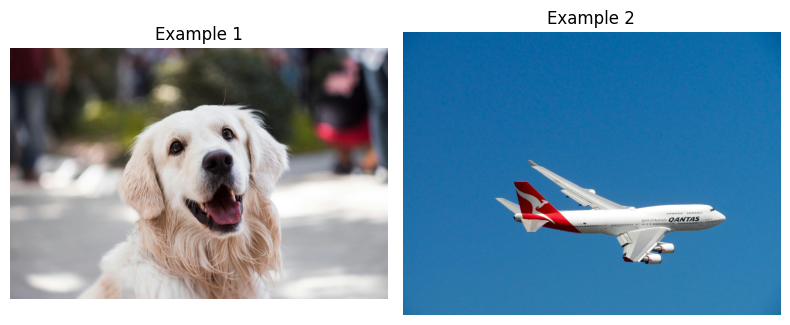

In [13]:
from PIL import Image
import matplotlib.pyplot as plt

example1 = Image.open('example1.jpg')
example2 = Image.open('example2.jpg')

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(example1)
plt.title("Example 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(example2)
plt.title("Example 2")
plt.axis("off")

plt.tight_layout()
plt.show()


# 13. Prepare Custom Images for Inference

In [14]:
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def load_image(image_path):
  image = Image.open(image_path)
  return new_transform(image).unsqueeze(0)

image_paths = ['example1.jpg', 'example2.jpg']
images = [load_image(img) for img in image_paths]


# 14. Predict on Custom Images

In [15]:
net.eval()
with torch.no_grad():
  for image in images:
    output = net(image)
    _, predicted = torch.max(output.data, 1)
    print(f'Prediction: {class_names[predicted.item()]}')

Prediction: dog
Prediction: plane
